# load the data, have a first look

In [42]:
# import libraries
import seaborn as sns
import pandas as pd

# load dataset
url = '/home/almuth/Documents/_data_science_bootcamp/Bootcamp/week7_supervised_ml/Regression/housing_iter_7/data/iter-7/data/housing_prices.csv'
housing = pd.read_csv(url)

# housing.rename(columns=lambda x: x.strip().replace(' ', ''), inplace=True)


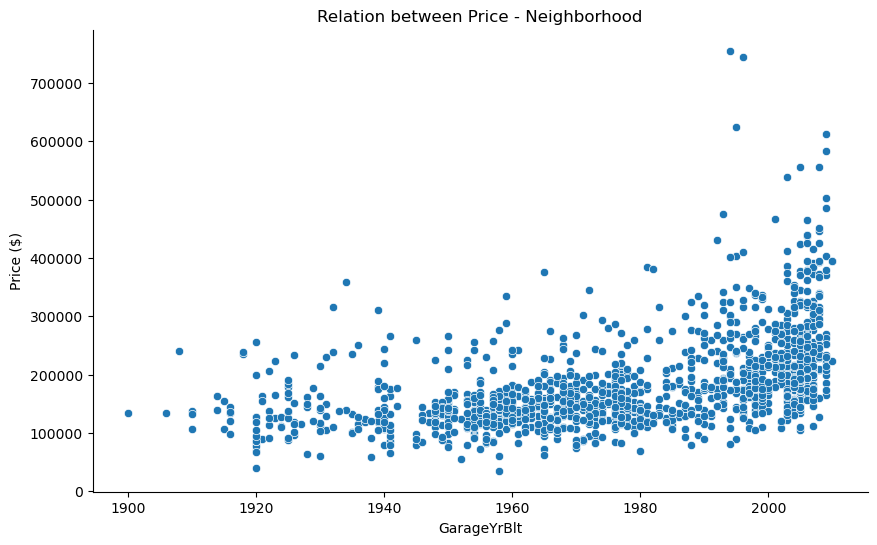

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=housing, x='GarageYrBlt', y='SalePrice')
plt.title('Relation between Price - Neighborhood')
plt.ylabel('Price ($)')
sns.despine()


# 2. Prepare and Split the data

In [44]:
# target variable SalePrice
from sklearn.model_selection import train_test_split
X = housing.copy()
y = X.pop("SalePrice")

X.drop("Id", axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


# 3. preparation for ordinal enconding

In [45]:
ordered_categories_column_names = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                   'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
# 'OverallQual','OverallCond'

ExterQual_cat = ['Po', 'Fa', 'TA', 'Gd', "Ex"]
ExterCond_cat = ['Po', 'Fa', 'TA', 'Gd', "Ex"]
BsmtQual_cat = ['Na', 'Po', 'Fa', 'TA', 'Gd', "Ex"]
BsmtCond_cat = ['Na', 'Po', 'Fa', 'TA', 'Gd', "Ex"]
BsmtExposure_cat = ['NA', 'No', 'Mn', 'Av', 'Gd']
BsmtFinType1_cat = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
BsmtFinType2_cat = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
HeatingQC_cat = ['Po', 'Fa', 'TA', 'Gd', "Ex"]
KitchenQual_cat = ['Po', 'Fa', 'TA', 'Gd', "Ex"]
FireplaceQu_cat = ['Na', 'Po', 'Fa', 'TA', 'Gd', "Ex"]
GarageFinish_cat = ['NA', 'Unf', 'RFn', 'Fin']
GarageQual_cat = ['Na', 'Po', 'Fa', 'TA', 'Gd', "Ex"]
GarageCond_cat = ['Na', 'Po', 'Fa', 'TA', 'Gd', "Ex"]
PoolQC_cat = ['Na', 'Po', 'Fa', 'TA', 'Gd', "Ex"]
Fence_cat = ['Na', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

ordinal_cats_list = [ExterQual_cat, ExterCond_cat, BsmtQual_cat, BsmtCond_cat, BsmtExposure_cat, BsmtFinType1_cat,
                     BsmtFinType2_cat, HeatingQC_cat, KitchenQual_cat, FireplaceQu_cat, GarageFinish_cat, GarageQual_cat, GarageCond_cat, PoolQC_cat, Fence_cat]


In [5]:
# X_cat_columns = X.select_dtypes(exclude='number').copy()

# X_num_columns = X.select_dtypes(include='number').copy()
# X_cat_ordered_columns = X_cat_columns[ordered_categories_column_names]
# X_cat_unordered_columns = X_cat_columns.drop(
#     ordered_categories_column_names, axis=1)


NOTE: MSE in itsef is not a useful number - needs to be compared to another model"s MSE

IMPORTANT

GridSearchCV
scoring = 'neg_mean_absolute_percentage_error'

# 4 importing libraries & creating pipes (num, ordered_cat and unorderd_cat)

In [46]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
KBest = SelectKBest(score_func=f_regression)


X_cat_columns = X.select_dtypes(exclude='number').copy()

# variables for the three pipes
X_num_columns = X.select_dtypes(include='number').copy()
X_cat_ordered_columns = X_cat_columns[ordered_categories_column_names]
X_cat_unordered_columns = X_cat_columns.drop(
    ordered_categories_column_names, axis=1)


# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(
    SimpleImputer(),
)
numeric_pipe

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
unordered_categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)
unordered_categoric_pipe
# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
ordered_categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OrdinalEncoder(categories=ordinal_cats_list,
                   handle_unknown='use_encoded_value', unknown_value=-1)
)
ordered_categoric_pipe

# Create a ColumnTransformer to apply the transformers to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, X_num_columns.columns),
        ('unordered', unordered_categoric_pipe, X_cat_unordered_columns.columns),
        ('ordered', ordered_categoric_pipe, X_cat_ordered_columns.columns)
    ])


RMSE should be small and the difference should be small between Train and test.
R^2 - -1 to 1 (1 ist best, -1 worst, 0 average)

# 5. Models & their score

In [7]:
scores = pd.DataFrame(
    {"model": ['dtr'], "R^2 Score Train": [""], "R^2 Score Test": [""]})

scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,


## 5.1 Model 1

In [8]:
# Combine the preprocessor and the model into a single pipeline
pipeline = make_pipeline(preprocessor, LinearRegression())

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model using RMSE
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Improved Model Train RMSE: {train_rmse:.2f}")
print(f"Improved Model Test RMSE: {test_rmse:.2f}")

print(f"Improved Model Train RMSE: {train_rmse:.2f}")
print(f"Improved Model Test RMSE: {test_rmse:.2f}")

# Evaluate the model using R^2 score
train_r2_m1 = r2_score(y_train, y_train_pred)
test_r2_m1 = r2_score(y_test, y_test_pred)

print(f"Improved Model Train R^2 Score: {train_r2_m1:.2f}")
print(f"Improved Model Test R^2 Score: {test_r2_m1:.2f}")


Improved Model Train RMSE: 21700.71
Improved Model Test RMSE: 32745.96
Improved Model Train RMSE: 21700.71
Improved Model Test RMSE: 32745.96
Improved Model Train R^2 Score: 0.92
Improved Model Test R^2 Score: 0.85


In [9]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['1'], "R^2 Score Train":[train_r2_m1], "R^2 Score Test": [test_r2_m1]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649


## 5.2 Model 2 DecisionTreeRegressor

In [10]:
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, DecisionTreeRegressor())

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_dtR = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'decisiontreeregressor__max_depth': range(3, 10),
    'decisiontreeregressor__min_samples_leaf': range(3, 10, 2),
    'decisiontreeregressor__min_samples_split': range(3, 39, 3),
    # 'decisiontreeregressor__max_leaf_nodes': range(1, 100),
    # 'decisiontreeregressor__max_features': range(1,79)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_dtR = RandomizedSearchCV(full_pipeline_dtR, param_grid_dtR,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_dtR.fit(X_train, y_train)
y_train_pred_dtR = search_dtR.predict(X_train)
y_test_pred_dtR = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_dtR, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_dtR, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_dtR.best_params_}")

# Evaluate the model using R^2 score
train_r2_m2 = r2_score(y_train, y_train_pred_dtR)
test_r2_m2 = r2_score(y_test, y_test_pred_dtR)

print(f"Train R^2 Score: {train_r2_m2:.2f}")
print(f"Model Test R^2 Score: {test_r2_m2:.2f}")


decisionTreeRegressor Train RMSE: 30431.71
decisionTreeRegressor Test RMSE: 35070.78
The best parameters are {'decisiontreeregressor__min_samples_split': 21, 'decisiontreeregressor__min_samples_leaf': 7, 'decisiontreeregressor__max_depth': 6, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.85
Model Test R^2 Score: 0.83


In [11]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['2'], "R^2 Score Train":[train_r2_m2], "R^2 Score Test": [test_r2_m2]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542


## 5.3 DecisionTreeRegressor with Kbest

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
KBest = SelectKBest(score_func=f_regression)


In [13]:
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, KBest, DecisionTreeRegressor())

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_dtR = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'decisiontreeregressor__max_depth': range(3, 10),
    'decisiontreeregressor__min_samples_leaf': range(3, 10, 2),
    'decisiontreeregressor__min_samples_split': range(3, 39, 3),
    'selectkbest__k': range(20, 65)
    # 'decisiontreeregressor__max_leaf_nodes': range(1, 100),
    # 'decisiontreeregressor__max_features': range(1,79)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_dtR = RandomizedSearchCV(full_pipeline_dtR, param_grid_dtR,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_dtR.fit(X_train, y_train)
y_train_pred_dtR = search_dtR.predict(X_train)
y_test_pred_dtR = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_dtR, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_dtR, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_dtR.best_params_}")

# Evaluate the model using R^2 score
train_r2_m3 = r2_score(y_train, y_train_pred_dtR)
test_r2_m3 = r2_score(y_test, y_test_pred_dtR)

print(f"Train R^2 Score: {train_r2_m3:.2f}")
print(f"Model Test R^2 Score: {test_r2_m3:.2f}")


decisionTreeRegressor Train RMSE: 33678.54
decisionTreeRegressor Test RMSE: 36777.96
The best parameters are {'selectkbest__k': 51, 'decisiontreeregressor__min_samples_split': 36, 'decisiontreeregressor__min_samples_leaf': 3, 'decisiontreeregressor__max_depth': 5, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.81
Model Test R^2 Score: 0.81


In [14]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['3'], "R^2 Score Train":[train_r2_m3], "R^2 Score Test": [test_r2_m3]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344


## 5.4 model 4 KNeighborsRegressor

In [15]:
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
neigh = KNeighborsRegressor(n_neighbors=1)


# initialize the pipe
full_pipeline_neigh = make_pipeline(
    preprocessor, neigh)
full_pipeline_neigh

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_neigh = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_neigh = RandomizedSearchCV(full_pipeline_neigh, param_grid_neigh,
                                  n_iter=2, cv=7, scoring='neg_mean_absolute_percentage_error', random_state=123, verbose=0)


# fit
search_neigh.fit(X_train, y_train)
y_train_pred_neigh = search_dtR.predict(X_train)
y_test_pred_neigh = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_neigh, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_neigh, squared=False)

print(f"KNeighborsRegressor Train RMSE: {train_rmse:.2f}")
print(f"KNeighborsRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_neigh.best_params_}")

# Evaluate the model using R^2 score
train_r2_m4 = r2_score(y_train, y_train_pred_neigh)
test_r2_m4 = r2_score(y_test, y_test_pred_neigh)

print(f"Train R^2 Score: {train_r2_m4:.2f}")
print(f"Model Test R^2 Score: {test_r2_m4:.2f}")


KNeighborsRegressor Train RMSE: 33678.54
KNeighborsRegressor Test RMSE: 36777.96
The best parameters are {'columntransformer__num__simpleimputer__strategy': 'mean'}
Train R^2 Score: 0.81
Model Test R^2 Score: 0.81


In [16]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['4'], "R^2 Score Train":[train_r2_m4], "R^2 Score Test": [test_r2_m4]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344


## 5.5 Model 5 KNeighborsRegressor with Kbest

In [17]:
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
neigh = KNeighborsRegressor(n_neighbors=1)


# initialize the pipe
full_pipeline_neigh = make_pipeline(
    preprocessor, KBest, neigh)
full_pipeline_neigh

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_neigh = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': range(20, 65)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_neigh = RandomizedSearchCV(full_pipeline_neigh, param_grid_neigh,
                                  n_iter=2, cv=7, scoring='neg_mean_absolute_percentage_error', random_state=123, verbose=0)


# fit
search_neigh.fit(X_train, y_train)
y_train_pred_neigh = search_dtR.predict(X_train)
y_test_pred_neigh = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_neigh, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_neigh, squared=False)

print(f"KNeighborsRegressor Train RMSE: {train_rmse:.2f}")
print(f"KNeighborsRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_neigh.best_params_}")

# Evaluate the model using R^2 score
train_r2_m5 = r2_score(y_train, y_train_pred_neigh)
test_r2_m5 = r2_score(y_test, y_test_pred_neigh)

print(f"Train R^2 Score: {train_r2_m5:.2f}")
print(f"Model Test R^2 Score: {test_r2_m5:.2f}")


KNeighborsRegressor Train RMSE: 33678.54
KNeighborsRegressor Test RMSE: 36777.96
The best parameters are {'selectkbest__k': 35, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.81
Model Test R^2 Score: 0.81


In [18]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['5'], "R^2 Score Train":[train_r2_m5], "R^2 Score Test": [test_r2_m5]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344


## 5.6  Model 6 - RandomForestRegressor


In [19]:
# from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


# initialize the pipe
full_pipeline_ran = make_pipeline(
    preprocessor, StandardScaler(), RandomForestRegressor(random_state=123))

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_ran = {
    "columntransformer__num__simpleimputer__strategy": ["mean", "median"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [None, 5, 11],
    "randomforestregressor__min_samples_split": [2, 5, 10],
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_ran = RandomizedSearchCV(full_pipeline_ran, param_grid_ran,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_ran.fit(X_train, y_train)
y_train_pred_ran = search_ran.predict(X_train)
y_test_pred_ran = search_ran.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_ran, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_ran, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_ran.best_params_}")

# Evaluate the model using R^2 score
train_r2_m6 = r2_score(y_train, y_train_pred_ran)
test_r2_m6 = r2_score(y_test, y_test_pred_ran)

print(f"Train R^2 Score: {train_r2_m6:.2f}")
print(f"Model Test R^2 Score: {test_r2_m6:.2f}")


decisionTreeRegressor Train RMSE: 13238.59
decisionTreeRegressor Test RMSE: 29055.73
The best parameters are {'standardscaler__with_std': True, 'standardscaler__with_mean': False, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__max_depth': None, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.97
Model Test R^2 Score: 0.88


In [20]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['6'], "R^2 Score Train":[train_r2_m6], "R^2 Score Test": [test_r2_m6]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626


## 5.7 Model 7 Randomforest with KBest

In [21]:
# initialize the pipe
full_pipeline_ran = make_pipeline(
    preprocessor, StandardScaler(), KBest, RandomForestRegressor(random_state=123))
full_pipeline_ran


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFull...
                                                  Index(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence'],
      dtype='object'))])),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7fe93714b010>)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=123))])

In [22]:
# from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


# initialize the pipe
full_pipeline_ran = make_pipeline(
    preprocessor, StandardScaler(), KBest, RandomForestRegressor(random_state=123))

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_ran = {
    "columntransformer__num__simpleimputer__strategy": ["mean", "median"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [None, 5, 11],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    'selectkbest__k': range(20, 65)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_ran = RandomizedSearchCV(full_pipeline_ran, param_grid_ran,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_ran.fit(X_train, y_train)
y_train_pred_ran = search_ran.predict(X_train)
y_test_pred_ran = search_ran.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_ran, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_ran, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_ran.best_params_}")

# Evaluate the model using R^2 score
train_r2_m7 = r2_score(y_train, y_train_pred_ran)
test_r2_m7 = r2_score(y_test, y_test_pred_ran)

print(f"Train R^2 Score: {train_r2_m7:.2f}")
print(f"Model Test R^2 Score: {test_r2_m7:.2f}")


decisionTreeRegressor Train RMSE: 16024.71
decisionTreeRegressor Test RMSE: 29186.51
The best parameters are {'standardscaler__with_std': True, 'standardscaler__with_mean': False, 'selectkbest__k': 41, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__max_depth': None, 'columntransformer__num__simpleimputer__strategy': 'mean'}
Train R^2 Score: 0.96
Model Test R^2 Score: 0.88


In [23]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['7'], "R^2 Score Train":[train_r2_m7], "R^2 Score Test": [test_r2_m7]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558


## 5.8 Model 8 Decisiontree with RFE

In [24]:
# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, RFE(DecisionTreeRegressor()))
full_pipeline_dtR


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFull...
                                                                                               'MnWw',
                                                                                               'GdWo',
                                                                                               'MnPrv',
                                                                                               'GdPrv']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  Index(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence'],
      dtype='object'))])),
                ('rfe', RFE(estimator=DecisionTreeRegressor()))])

In [25]:
from sklearn.feature_selection import RFE

# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, RFE(estimator=DecisionTreeRegressor()))

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_dtR_RFE = {
    # 'rfe__feature':column_names,
    # 'rfe__importance':feature_importances,
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'rfe__estimator__min_samples_leaf': range(2),
    'rfe__estimator__max_leaf_nodes': range(1, 40),
    'rfe__estimator__max_features': range(1, 79)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_dtR = RandomizedSearchCV(full_pipeline_dtR, param_grid_dtR_RFE,
                                n_iter=10, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_dtR.fit(X_train, y_train)
y_train_pred_dtR = search_dtR.predict(X_train)
y_test_pred_dtR = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_dtR, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_dtR, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_dtR.best_params_}")

# Evaluate the model using R^2 score
train_r2_m8 = r2_score(y_train, y_train_pred_dtR)
test_r2_m8 = r2_score(y_test, y_test_pred_dtR)

print(f"Train R^2 Score: {train_r2_m8:.2f}")
print(f"Model Test R^2 Score: {test_r2_m8:.2f}")


/home/almuth/Documents/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
42 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/home/almuth/Documents/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/almuth/Documents/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/almuth/Documents/anaconda3/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.p

decisionTreeRegressor Train RMSE: 36179.65
decisionTreeRegressor Test RMSE: 36871.90
The best parameters are {'rfe__estimator__min_samples_leaf': 1, 'rfe__estimator__max_leaf_nodes': 18, 'rfe__estimator__max_features': 48, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.79
Model Test R^2 Score: 0.81


In [26]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['8'], "R^2 Score Train":[train_r2_m8], "R^2 Score Test": [test_r2_m8]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558
0,8,0.785141,0.809374


## 5.9 LinearRegression with RFE

In [49]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
# initialize the pipe
full_pipeline_ran = make_pipeline(
    preprocessor, StandardScaler(), RFE(estimator=LinearRegression()))

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_ran = {
    "columntransformer__num__simpleimputer__strategy": ["mean", "median"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False]
    # "rfe__estimator__n_estimators": [100, 200, 300],
    # "rfe__estimator__max_depth": [None, 5, 11],
    # "rfe__estimator__min_samples_split": [2, 5, 10],
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_ran = RandomizedSearchCV(full_pipeline_ran, param_grid_ran,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_ran.fit(X_train, y_train)
y_train_pred_ran = search_ran.predict(X_train)
y_test_pred_ran = search_ran.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_ran, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_ran, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_ran.best_params_}")

# Evaluate the model using R^2 score
train_r2_m6 = r2_score(y_train, y_train_pred_ran)
test_r2_m6 = r2_score(y_test, y_test_pred_ran)

print(f"Train R^2 Score: {train_r2_m6:.2f}")
print(f"Model Test R^2 Score: {test_r2_m6:.2f}")


decisionTreeRegressor Train RMSE: 25906.89
decisionTreeRegressor Test RMSE: 34729.66
The best parameters are {'standardscaler__with_std': False, 'standardscaler__with_mean': True, 'columntransformer__num__simpleimputer__strategy': 'mean'}
Train R^2 Score: 0.89
Model Test R^2 Score: 0.83


## 5.10 Model 10 randomforest with variance threshold

In [29]:
# from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)

# initialize the pipe
full_pipeline_ran = make_pipeline(
    preprocessor, StandardScaler(), KBest, selector, RandomForestRegressor(random_state=123))

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_ran = {
    "columntransformer__num__simpleimputer__strategy": ["mean", "median"],
    "standardscaler__with_mean": [True, False],
    "standardscaler__with_std": [True, False],
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [None, 5, 11],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    'selectkbest__k': range(20, 65)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_ran = RandomizedSearchCV(full_pipeline_ran, param_grid_ran,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_ran.fit(X_train, y_train)
y_train_pred_ran = search_ran.predict(X_train)
y_test_pred_ran = search_ran.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_ran, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_ran, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_ran.best_params_}")

# Evaluate the model using R^2 score
train_r2_m10 = r2_score(y_train, y_train_pred_ran)
test_r2_m10 = r2_score(y_test, y_test_pred_ran)

print(f"Train R^2 Score: {train_r2_m10:.2f}")
print(f"Model Test R^2 Score: {test_r2_m10:.2f}")


decisionTreeRegressor Train RMSE: 16024.71
decisionTreeRegressor Test RMSE: 29186.51
The best parameters are {'standardscaler__with_std': True, 'standardscaler__with_mean': False, 'selectkbest__k': 41, 'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__max_depth': None, 'columntransformer__num__simpleimputer__strategy': 'mean'}
Train R^2 Score: 0.96
Model Test R^2 Score: 0.88


In [30]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['10'], "R^2 Score Train":[train_r2_m10], "R^2 Score Test": [test_r2_m10]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558
0,8,0.785141,0.809374
0,10,0.957849,0.880558


## 5.11 Model 11 KneighborsRegressor with KBest and variance threshhold

In [31]:
from sklearn.feature_selection import VarianceThreshold
neigh = KNeighborsRegressor(n_neighbors=1)
selector = VarianceThreshold(threshold=0.01)

# initialize the pipe
full_pipeline_neigh = make_pipeline(
    preprocessor, selector, KBest, neigh)
full_pipeline_neigh

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_neigh = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': range(20, 65)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_neigh = RandomizedSearchCV(full_pipeline_neigh, param_grid_neigh,
                                  n_iter=2, cv=7, scoring='neg_mean_absolute_percentage_error', random_state=123, verbose=0)


# fit
search_neigh.fit(X_train, y_train)
y_train_pred_neigh = search_dtR.predict(X_train)
y_test_pred_neigh = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_neigh, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_neigh, squared=False)

print(f"KNeighborsRegressor Train RMSE: {train_rmse:.2f}")
print(f"KNeighborsRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_neigh.best_params_}")

# Evaluate the model using R^2 score
train_r2_m11 = r2_score(y_train, y_train_pred_neigh)
test_r2_m11 = r2_score(y_test, y_test_pred_neigh)

print(f"Train R^2 Score: {train_r2_m11:.2f}")
print(f"Model Test R^2 Score: {test_r2_m11:.2f}")


KNeighborsRegressor Train RMSE: 36179.65
KNeighborsRegressor Test RMSE: 36871.90
The best parameters are {'selectkbest__k': 35, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.79
Model Test R^2 Score: 0.81


In [32]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['11'], "R^2 Score Train":[train_r2_m11], "R^2 Score Test": [test_r2_m11]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558
0,8,0.785141,0.809374
0,10,0.957849,0.880558


## 5.12 Model 12 select from model dtr and then dtr

In [33]:
from sklearn.feature_selection import SelectFromModel
select_model_tree = SelectFromModel(DecisionTreeRegressor(),
                                    threshold=None)


In [34]:
# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, select_model_tree, DecisionTreeRegressor())
full_pipeline_dtR


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFull...
                                                                                  unknown_value=-1))]),
                                                  Index(['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence'],
      dtype='object'))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=DecisionTreeRegressor())),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [35]:
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, select_model_tree, DecisionTreeRegressor())

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_dtR = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'decisiontreeregressor__max_depth': range(3, 10),
    'decisiontreeregressor__min_samples_leaf': range(3, 10, 2),
    'decisiontreeregressor__min_samples_split': range(3, 39, 3),
    # 'decisiontreeregressor__max_leaf_nodes': range(1, 100),
    # 'decisiontreeregressor__max_features': range(1,79)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_dtR = RandomizedSearchCV(full_pipeline_dtR, param_grid_dtR,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_dtR.fit(X_train, y_train)
y_train_pred_dtR = search_dtR.predict(X_train)
y_test_pred_dtR = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_dtR, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_dtR, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_dtR.best_params_}")

# Evaluate the model using R^2 score
train_r2_m12 = r2_score(y_train, y_train_pred_dtR)
test_r2_m12 = r2_score(y_test, y_test_pred_dtR)

print(f"Train R^2 Score: {train_r2_m12:.2f}")
print(f"Model Test R^2 Score: {test_r2_m12:.2f}")


decisionTreeRegressor Train RMSE: 30674.50
decisionTreeRegressor Test RMSE: 35281.55
The best parameters are {'decisiontreeregressor__min_samples_split': 21, 'decisiontreeregressor__min_samples_leaf': 7, 'decisiontreeregressor__max_depth': 6, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.85
Model Test R^2 Score: 0.83


In [36]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['12'], "R^2 Score Train":[train_r2_m12], "R^2 Score Test": [test_r2_m12]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558
0,8,0.785141,0.809374
0,10,0.957849,0.880558


## 5.13 Model 13 select from model dtr and then KneighborsRegressor with KBest 

In [37]:
from sklearn.feature_selection import SelectFromModel
select_model_tree = SelectFromModel(DecisionTreeRegressor(),
                                    threshold=None)


In [38]:
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
neigh = KNeighborsRegressor(n_neighbors=1)


# initialize the pipe
full_pipeline_neigh = make_pipeline(
    preprocessor, select_model_tree, KBest, neigh)
full_pipeline_neigh

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_neigh = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    # 'selectkbest__k': range(10, 65)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_neigh = RandomizedSearchCV(full_pipeline_neigh, param_grid_neigh,
                                  n_iter=2, cv=7, scoring='neg_mean_absolute_percentage_error', random_state=123, verbose=0)


# fit
search_neigh.fit(X_train, y_train)
y_train_pred_neigh = search_dtR.predict(X_train)
y_test_pred_neigh = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_neigh, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_neigh, squared=False)

print(f"KNeighborsRegressor Train RMSE: {train_rmse:.2f}")
print(f"KNeighborsRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_neigh.best_params_}")

# Evaluate the model using R^2 score
train_r2_m13 = r2_score(y_train, y_train_pred_neigh)
test_r2_m13 = r2_score(y_test, y_test_pred_neigh)

print(f"Train R^2 Score: {train_r2_m13:.2f}")
print(f"Model Test R^2 Score: {test_r2_m13:.2f}")


KNeighborsRegressor Train RMSE: 30674.50
KNeighborsRegressor Test RMSE: 35281.55
The best parameters are {'columntransformer__num__simpleimputer__strategy': 'mean'}
Train R^2 Score: 0.85
Model Test R^2 Score: 0.83


In [39]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['13'], "R^2 Score Train":[train_r2_m13], "R^2 Score Test": [test_r2_m13]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558
0,8,0.785141,0.809374
0,10,0.957849,0.880558


## 5.14 Model 14 variance threshold, Kbest, randomforestregressor

In [40]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)

# initialize the pipe
full_pipeline_dtR = make_pipeline(
    preprocessor, selector, KBest, RandomForestRegressor())

# train a DecisionTree with GridSearch cross validation
# parameter grid
param_grid_dtR = {
    'columntransformer__num__simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': range(20, 65)
    # 'decisiontreeregressor__max_depth': range(3, 10),
    # 'decisiontreeregressor__min_samples_leaf': range(3, 10, 2),
    # 'decisiontreeregressor__min_samples_split': range(3, 39, 3),
    # 'decisiontreeregressor__max_leaf_nodes': range(1, 100),
    # 'decisiontreeregressor__max_features': range(1,79)
}

# define cross validation
#search_dt = GridSearchCV(full_pipeline_dt,param_grid_dt,cv=5,verbose=0)
search_dtR = RandomizedSearchCV(full_pipeline_dtR, param_grid_dtR,
                                n_iter=2, cv=7, scoring='r2', random_state=123, verbose=0)


# fit
search_dtR.fit(X_train, y_train)
y_train_pred_dtR = search_dtR.predict(X_train)
y_test_pred_dtR = search_dtR.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_dtR, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_dtR, squared=False)

print(f"decisionTreeRegressor Train RMSE: {train_rmse:.2f}")
print(f"decisionTreeRegressor Test RMSE: {test_rmse:.2f}")

print(f"The best parameters are {search_dtR.best_params_}")

# Evaluate the model using R^2 score
train_r2_m14 = r2_score(y_train, y_train_pred_dtR)
test_r2_m14 = r2_score(y_test, y_test_pred_dtR)

print(f"Train R^2 Score: {train_r2_m14:.2f}")
print(f"Model Test R^2 Score: {test_r2_m14:.2f}")


decisionTreeRegressor Train RMSE: 11967.07
decisionTreeRegressor Test RMSE: 28876.15
The best parameters are {'selectkbest__k': 35, 'columntransformer__num__simpleimputer__strategy': 'median'}
Train R^2 Score: 0.98
Model Test R^2 Score: 0.88


In [41]:
scores = pd.concat([scores, pd.DataFrame(
    {"model": ['14'], "R^2 Score Train":[train_r2_m14], "R^2 Score Test": [test_r2_m14]})], axis=0)
scores


,model,R^2 Score Train,R^2 Score Test
0,dtr,,
0,1,0.922701,0.849649
0,2,0.847988,0.827542
0,3,0.813821,0.810344
0,4,0.813821,0.810344
0,5,0.813821,0.810344
0,6,0.971232,0.881626
0,7,0.957849,0.880558
0,8,0.785141,0.809374
0,10,0.957849,0.880558


# 6. Correlation Matrix, see what to drop or PCA

/tmp/ipykernel_49353/3031263115.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = X_train.corr().abs()


['GarageArea']


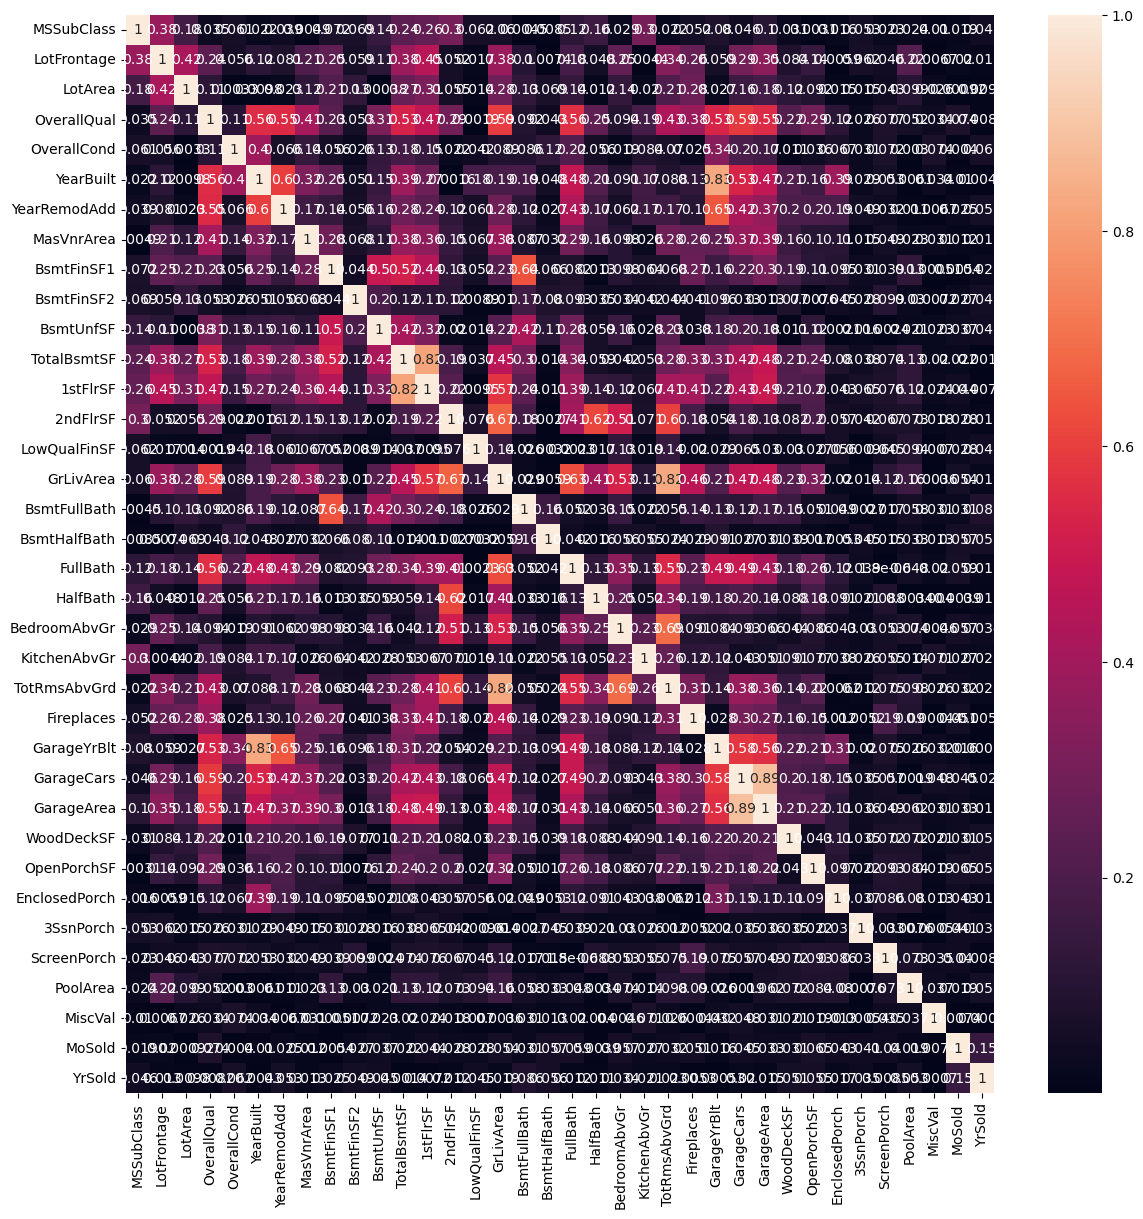

In [34]:
import matplotlib.pyplot as plt
import numpy as np
corrMatrix = X_train.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrMatrix, annot=True)

# Select the upper triangle of the correlation matrix.
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))

# Find the index of those feature columns with correlation greater than 0.95.
to_drop = [column for column in upper.columns if any(upper[column] > 0.87)]
print(to_drop)


In [24]:
# # Drop the columns from the train set.
# X_train_selected = X_train.drop(columns=to_drop)

# # Drop the columns from the test set.
# X_test_selected = X_test.drop(columns=to_drop)


In [25]:
# make df with the two features we want to PCA
garage_corr_features = X[['GarageArea', 'GarageCars']].copy()


In [26]:
#  set configuration to pandas and importy library
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(transform_output="pandas")
garage_corr_features = X[['GarageArea', 'GarageCars']].copy()
# initialize PCA for covering 90% of variance
pca = PCA(n_components=0.87)
# initialize PCA for one column
pca1 = PCA(n_components=1)

df_pca0 = pca.fit_transform(garage_corr_features)
X_num_columns['GarageAreaCars'] = df_pca0['pca0']
X_num_columns.drop(['GarageArea'], axis=1, inplace=True)


# Test for kaggle

In [ ]:
# import Kaggle test data
#competition_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# import Kaggle test data
url = "https://drive.google.com/file/d/1jnn7sVeWjrKyWe2DDkpbtGpM-vCmWsnW/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
competition_data = pd.read_csv(path)


In [ ]:
my_test_X = competition_data.drop(columns=["Id"])


In [ ]:
my_submission = pd.DataFrame(competition_data["Id"])
my_submission["SalePrice"] = gb_search.predict(my_test_X)

my_submission.to_csv('my_submission_1.csv', index=False)


#from google.colab import files
# files.download('my_submission_1.csv')
